
# Insurance Experiment Analysis (v2 — robust plots)

Diese Version ist robuster gegen unterschiedliche Episoden-Längen je Seed und gegen Moving-Average-Kürzungen.


In [49]:

from pathlib import Path
import json

# Auto-pick the newest results subdir; override manually if needed.
base_dir = Path("results")
subdirs = sorted([d for d in base_dir.glob("*") if d.is_dir()])
if not subdirs:
    raise FileNotFoundError("No subdirectories found under ./results. Run your experiment script first.")
results_dir = subdirs[-1]
print("Using results directory:", results_dir)

# Manual override example:
# results_dir = Path("results/2025_08_10_143012_(300ep_1000h_8-25d_4k_0.05e_0.00a_0.999g)")


Using results directory: results/2025_08_10_192924_(100ep_1000h_8-25d_4k_0.05e_0.00a_1.00g)


In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

summary_df = pd.read_csv(results_dir / "experiment_summary.csv")
with open(results_dir / "run_meta.json", "r") as f:
    meta = json.load(f)
print("Summary rows:", summary_df.shape[0])
meta


Summary rows: 1500


{'git_commit': '18a8ae4e0a7164b82f81ef75ace2961a6756a5c2',
 'episodes': 100,
 'horizon': 1000,
 'min_delay': 8,
 'max_delay': 25,
 'k_repeat': 4,
 'eps': 0.05,
 'alpha': 0.0004,
 'gamma': 0.999,
 'seeds': [10, 11, 12, 13, 14],
 'scaling': 1}

In [51]:

# Load per-run CSVs
def parse_variant_seed(p: Path):
    name = p.stem
    parts = name.split("_")
    # try last two tokens
    variant = parts[-2]
    seed = int(parts[-1])
    return variant, seed

train_files = sorted(results_dir.glob("train_metrics_*_*.csv"))
eval_files = sorted(results_dir.glob("eval_metrics_*_*.csv"))

train_list = []
for p in train_files:
    df = pd.read_csv(p)
    v, s = parse_variant_seed(p)
    df["variant"] = df.get("variant", v)
    df["seed"] = df.get("seed", s)
    for col in ["ez_steps","ez_phases","ez_repeats","exploration_steps","exploration_rate"]:
        if col not in df.columns:
            df[col] = 0
    train_list.append(df)
train_df = pd.concat(train_list, ignore_index=True) if train_list else pd.DataFrame()

eval_list = []
for p in eval_files:
    df = pd.read_csv(p)
    v, s = parse_variant_seed(p)
    df["variant"] = df.get("variant", v)
    df["seed"] = df.get("seed", s)
    eval_list.append(df)
eval_df = pd.concat(eval_list, ignore_index=True) if eval_list else pd.DataFrame()

train_df.head(), (None if eval_df.empty else eval_df.head())


(    variant  seed  episode         return  steps  accept_rate  avg_premium  loss_paid_sum   min_capital  final_capital  bankrupt  \
 0  Annealed    10        1   85604.164403   1000        0.799   386.114148 -221079.846166  16603.854982  135604.164403         0   
 1  Annealed    10        2  128642.117808   1000        0.805   380.676775 -173678.735675  50000.000000  178642.117808         0   
 2  Annealed    10        3   42099.069392   1000        0.808   382.213866 -264719.740655  50000.000000   92099.069392         0   
 3  Annealed    10        4  100636.033797   1000        0.812   385.809857 -206107.690753  50000.000000  150636.033797         0   
 4  Annealed    10        5   62994.174457   1000        0.802   387.993521 -246422.646221  40916.929694  112994.174457         0   
 
    time_to_ruin  ez_steps  ez_phases  ez_repeats  exploration_steps  exploration_rate  
 0            -1         0          0           0                788             0.788  
 1            -1      

In [52]:

# Robust helpers
from typing import List, Tuple, Optional

def moving_average_full_length(a, k=20):
    """Moving average, returns same length as input (left padded with NaN)."""
    if k <= 1:
        return np.asarray(a, dtype=float)
    a = np.asarray(a, dtype=float)
    if len(a) == 0:
        return a
    if len(a) < k:
        # not enough points: return all-NaN except last valid mean if len>=1
        pad = np.full(len(a), np.nan)
        return pad
    ret = np.cumsum(np.insert(a, 0, 0.0))
    out = (ret[k:] - ret[:-k]) / float(k)
    pad_left = np.full(k-1, np.nan)
    return np.concatenate([pad_left, out])

def prepare_variant_series(g: pd.DataFrame, value_col: str, ma_k: Optional[int]=None) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    For one variant group g:
      - split by seed
      - sort by episode
      - optionally apply MA keeping full length (NaN padded)
      - align all seeds by the minimum available length
      - drop leading NaNs (from MA) consistently across seeds
      - return common x (1..L) and list of y arrays of length L
    """
    series = []
    min_len = None
    for s, gs in g.groupby("seed"):
        gs = gs.sort_values("episode")
        y = gs[value_col].to_numpy()
        if ma_k is not None:
            y = moving_average_full_length(y, k=ma_k)
        if min_len is None or len(y) < min_len:
            min_len = len(y)
        series.append(y)
    if min_len is None or min_len == 0:
        return np.array([]), []
    # Trim all to min_len
    series = [y[:min_len] for y in series]
    # Determine first index where all seeds have non-NaN (avoid MA padding mismatch)
    mask_valid = ~np.any(np.isnan(np.vstack(series)), axis=0)
    if not np.any(mask_valid):
        # if everything NaN (e.g., too short), just return zeros to avoid crashes
        L = min_len
        x = np.arange(1, L+1)
        series = [np.zeros(L) for _ in series]
        return x, series
    # keep only valid columns
    series = [y[mask_valid] for y in series]
    L = series[0].shape[0]
    x = np.arange(1, L+1)
    return x, series

def plot_mean_std(ax, x, ys, label=None):
    if not ys:
        return
    Y = np.vstack(ys)
    mu = np.nanmean(Y, axis=0)
    sd = np.nanstd(Y, axis=0)
    ax.plot(x, mu, label=label)
    ax.fill_between(x, mu - sd, mu + sd, alpha=0.2)


## Training: Return per Episode

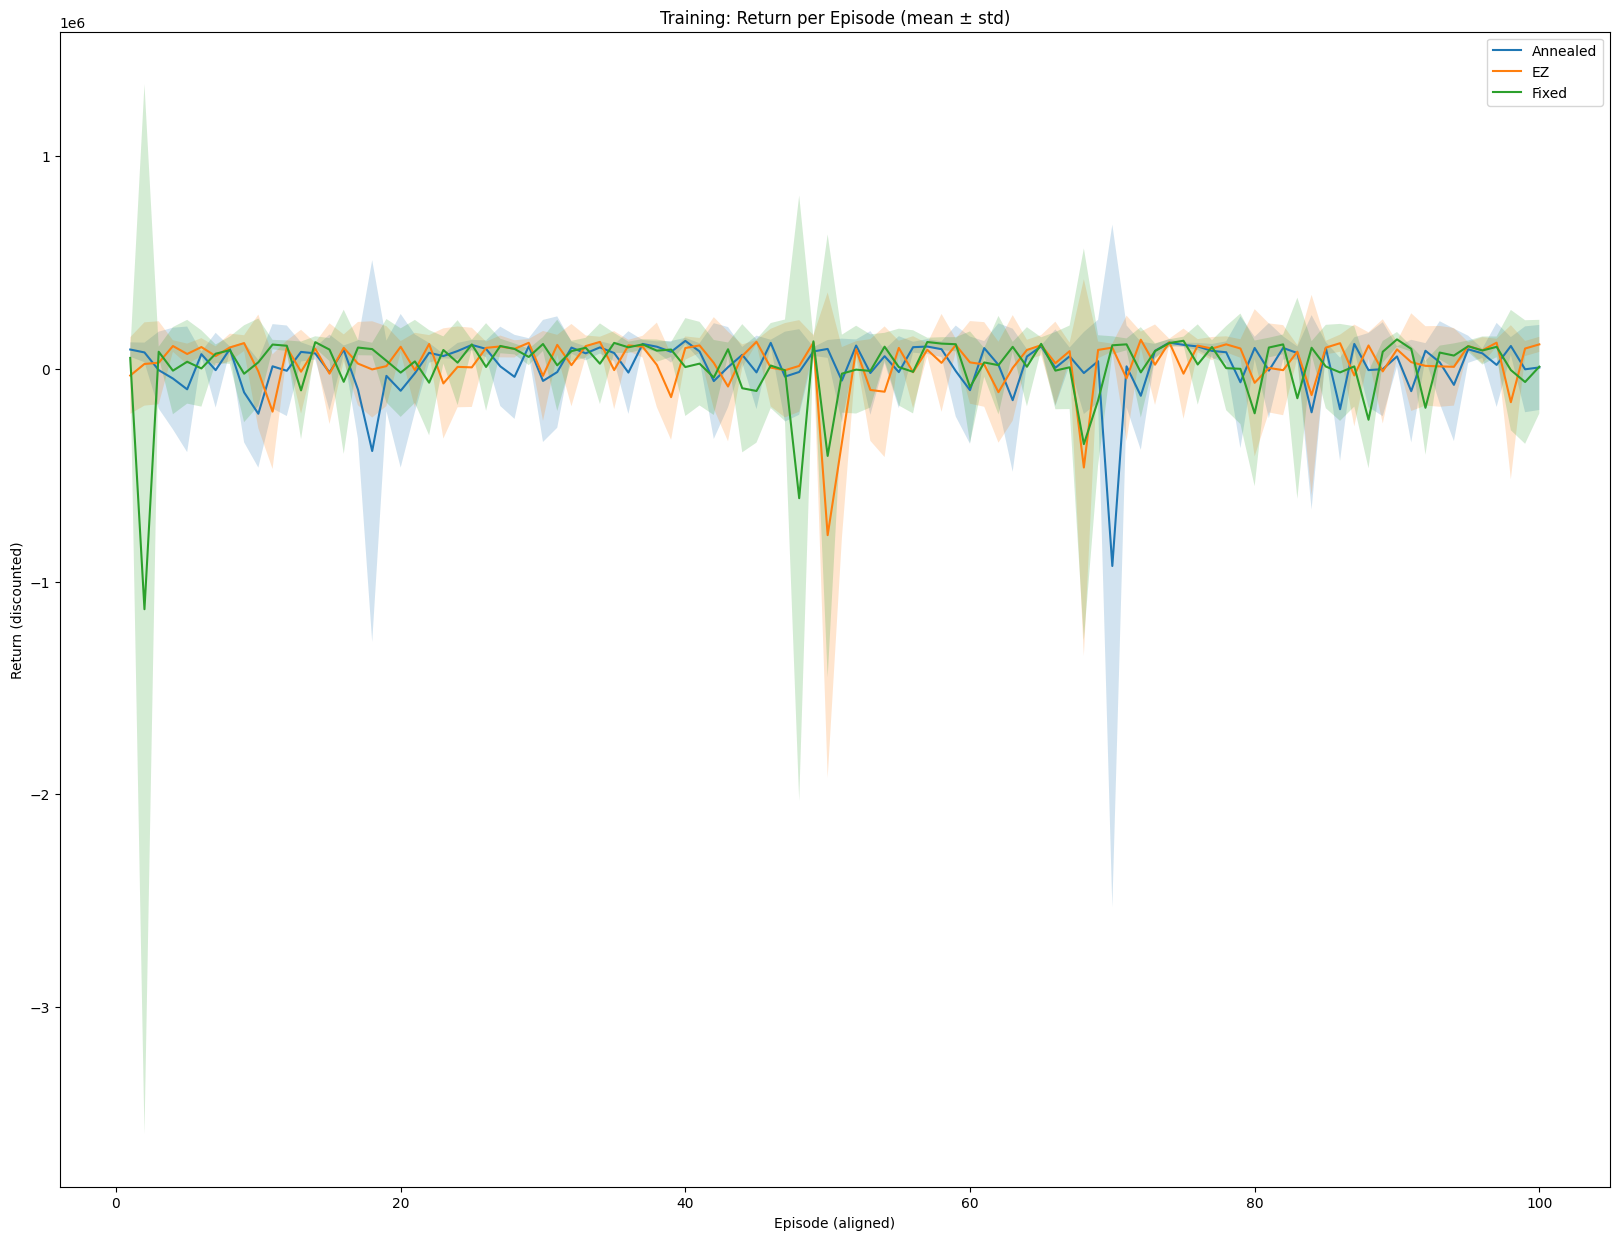

In [53]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="return", ma_k=None)
        if len(x) > 0:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Return (discounted)")
    ax.set_title("Training: Return per Episode (mean ± std)")
    ax.legend()
    plt.show()


## Acceptance rate over training (robust)

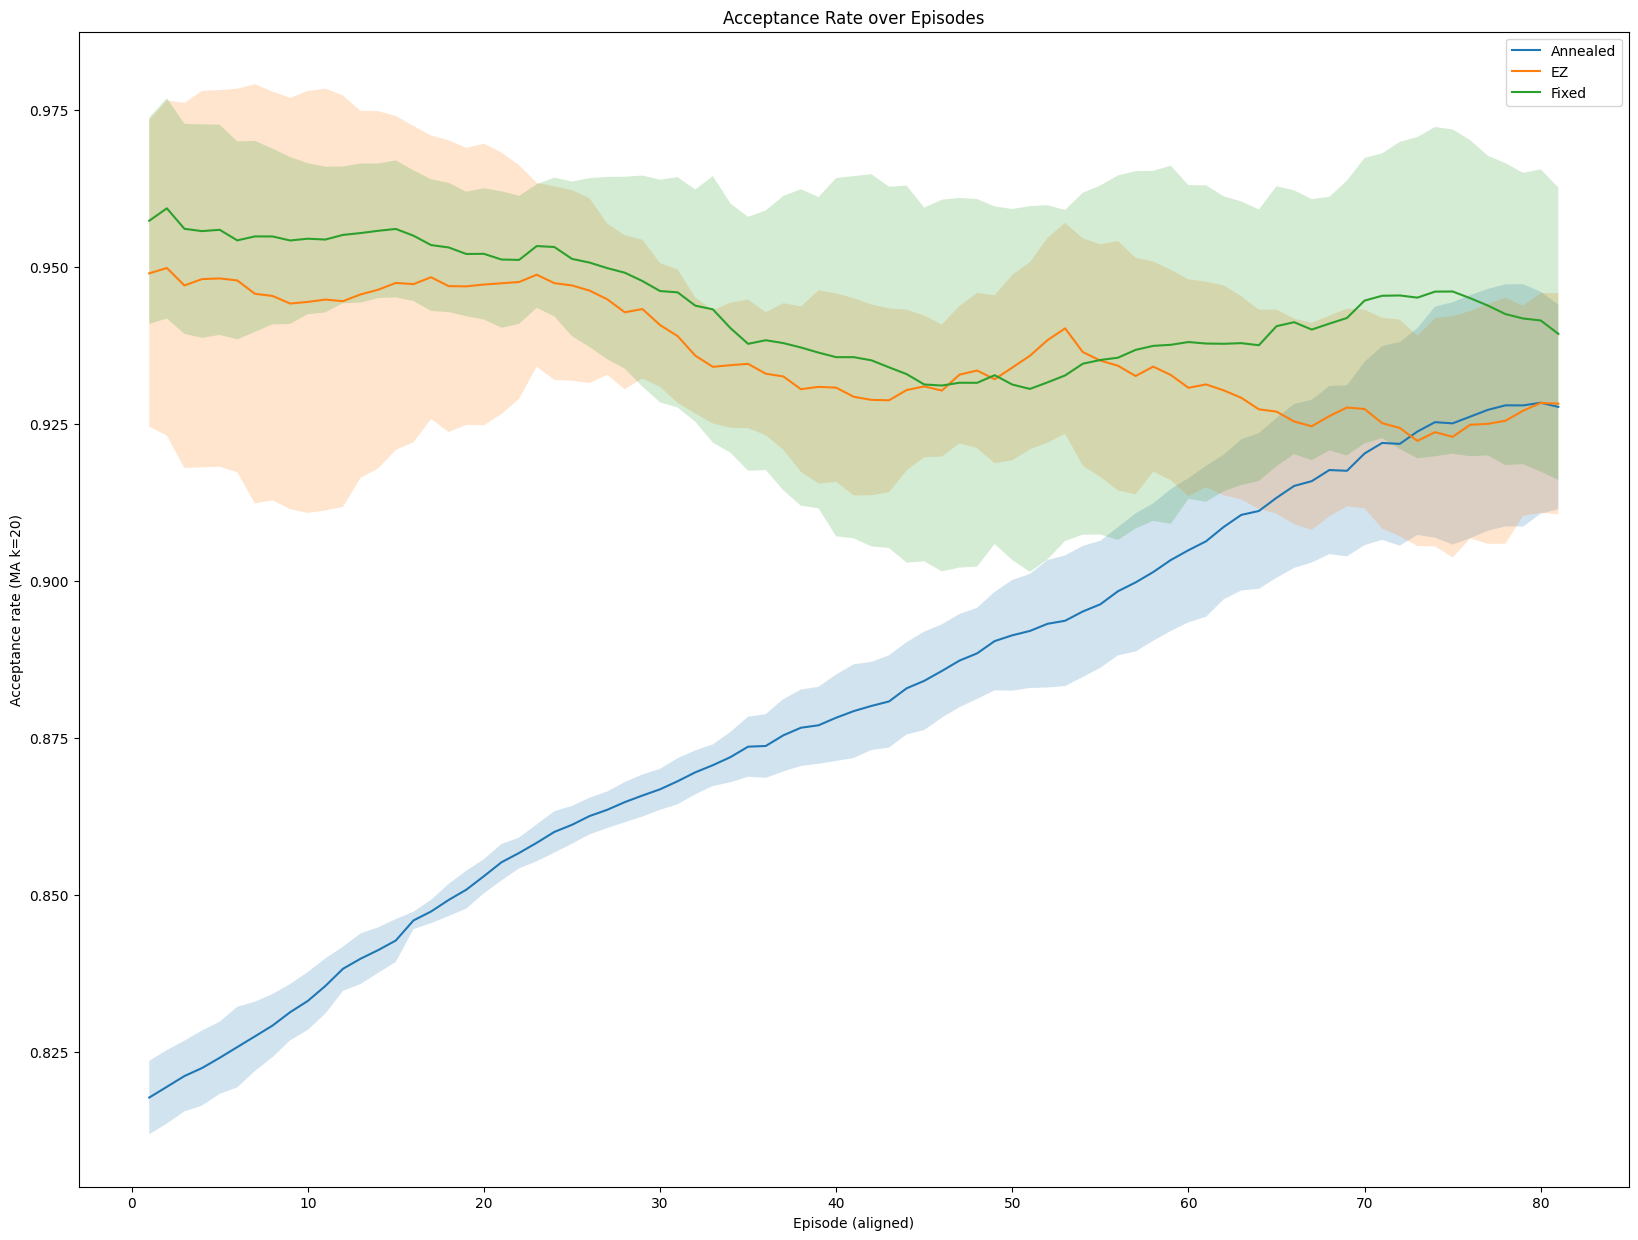

In [54]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="accept_rate", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Acceptance rate (MA k=20)")
    ax.set_title("Acceptance Rate over Episodes")
    ax.legend()
    plt.show()


## Average premium of accepted policies (robust)

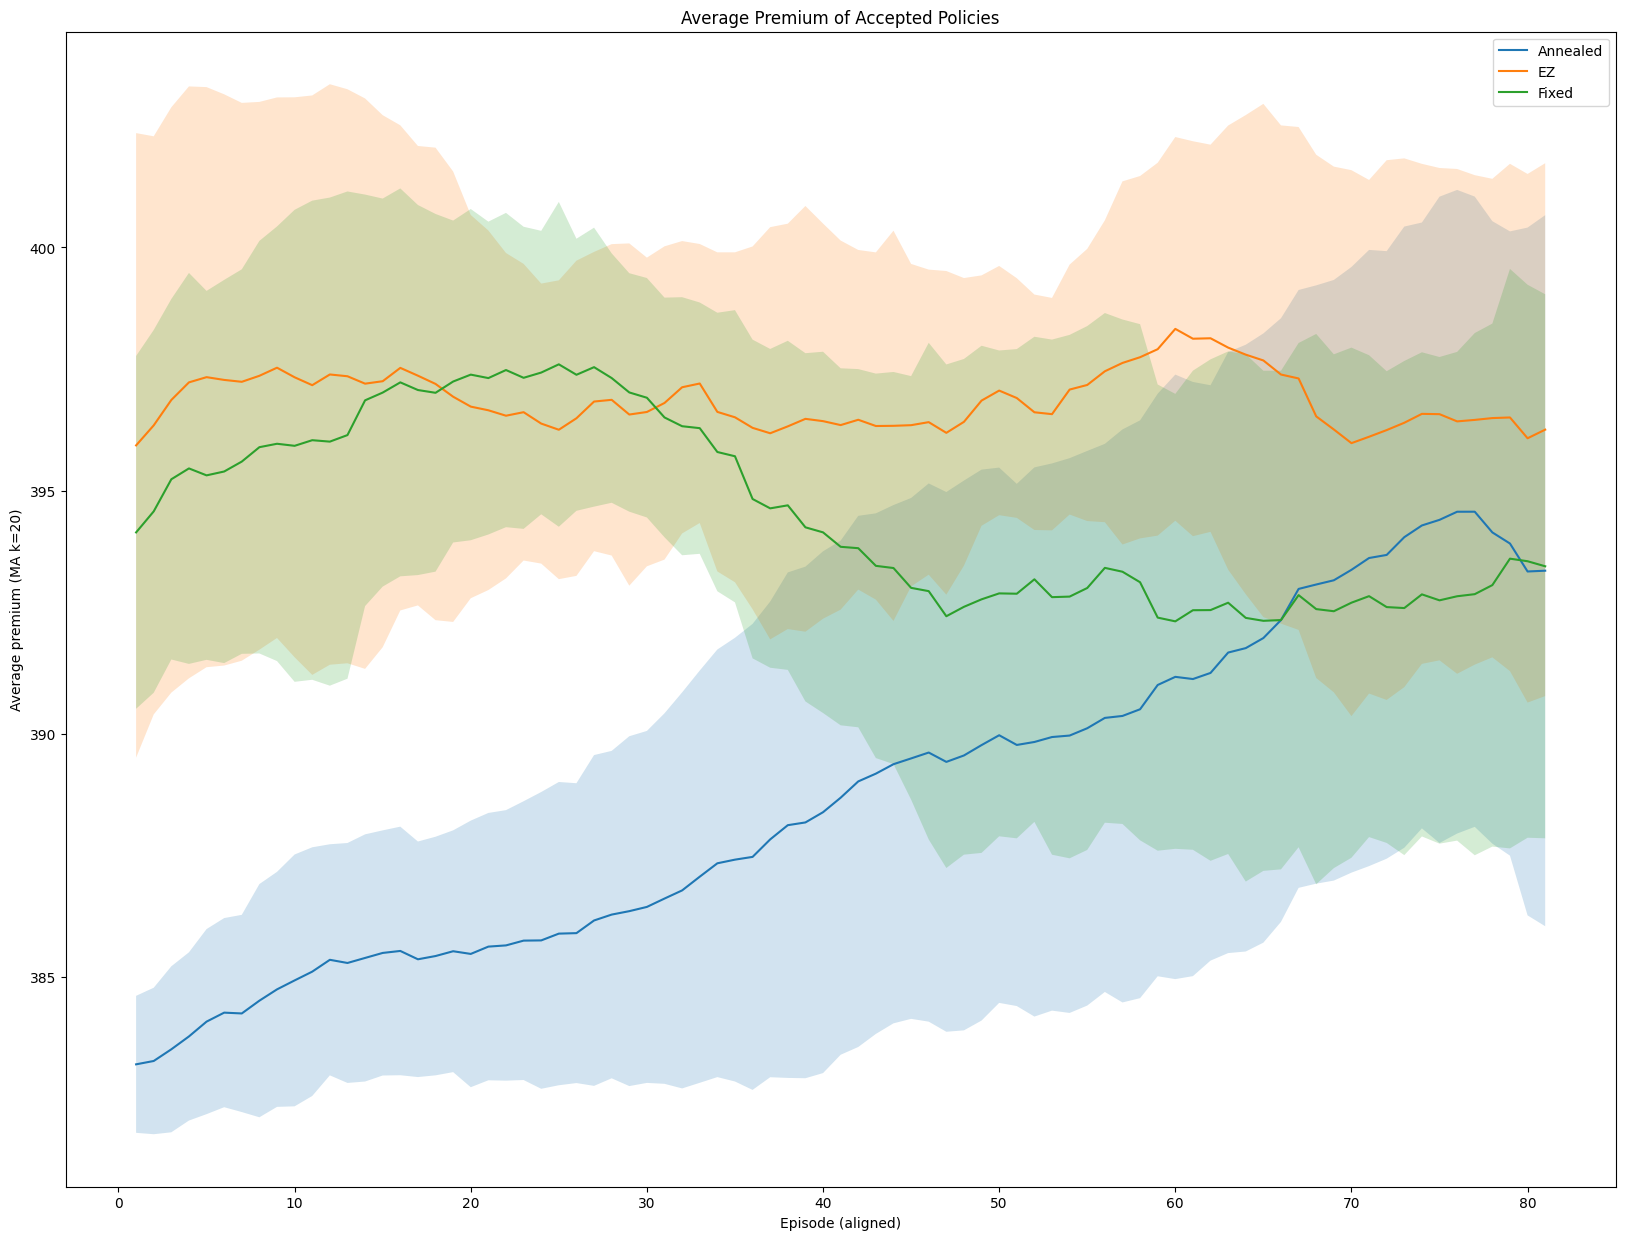

In [55]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="avg_premium", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Average premium (MA k=20)")
    ax.set_title("Average Premium of Accepted Policies")
    ax.legend()
    plt.show()


## Capital over episodes (min & final, robust)

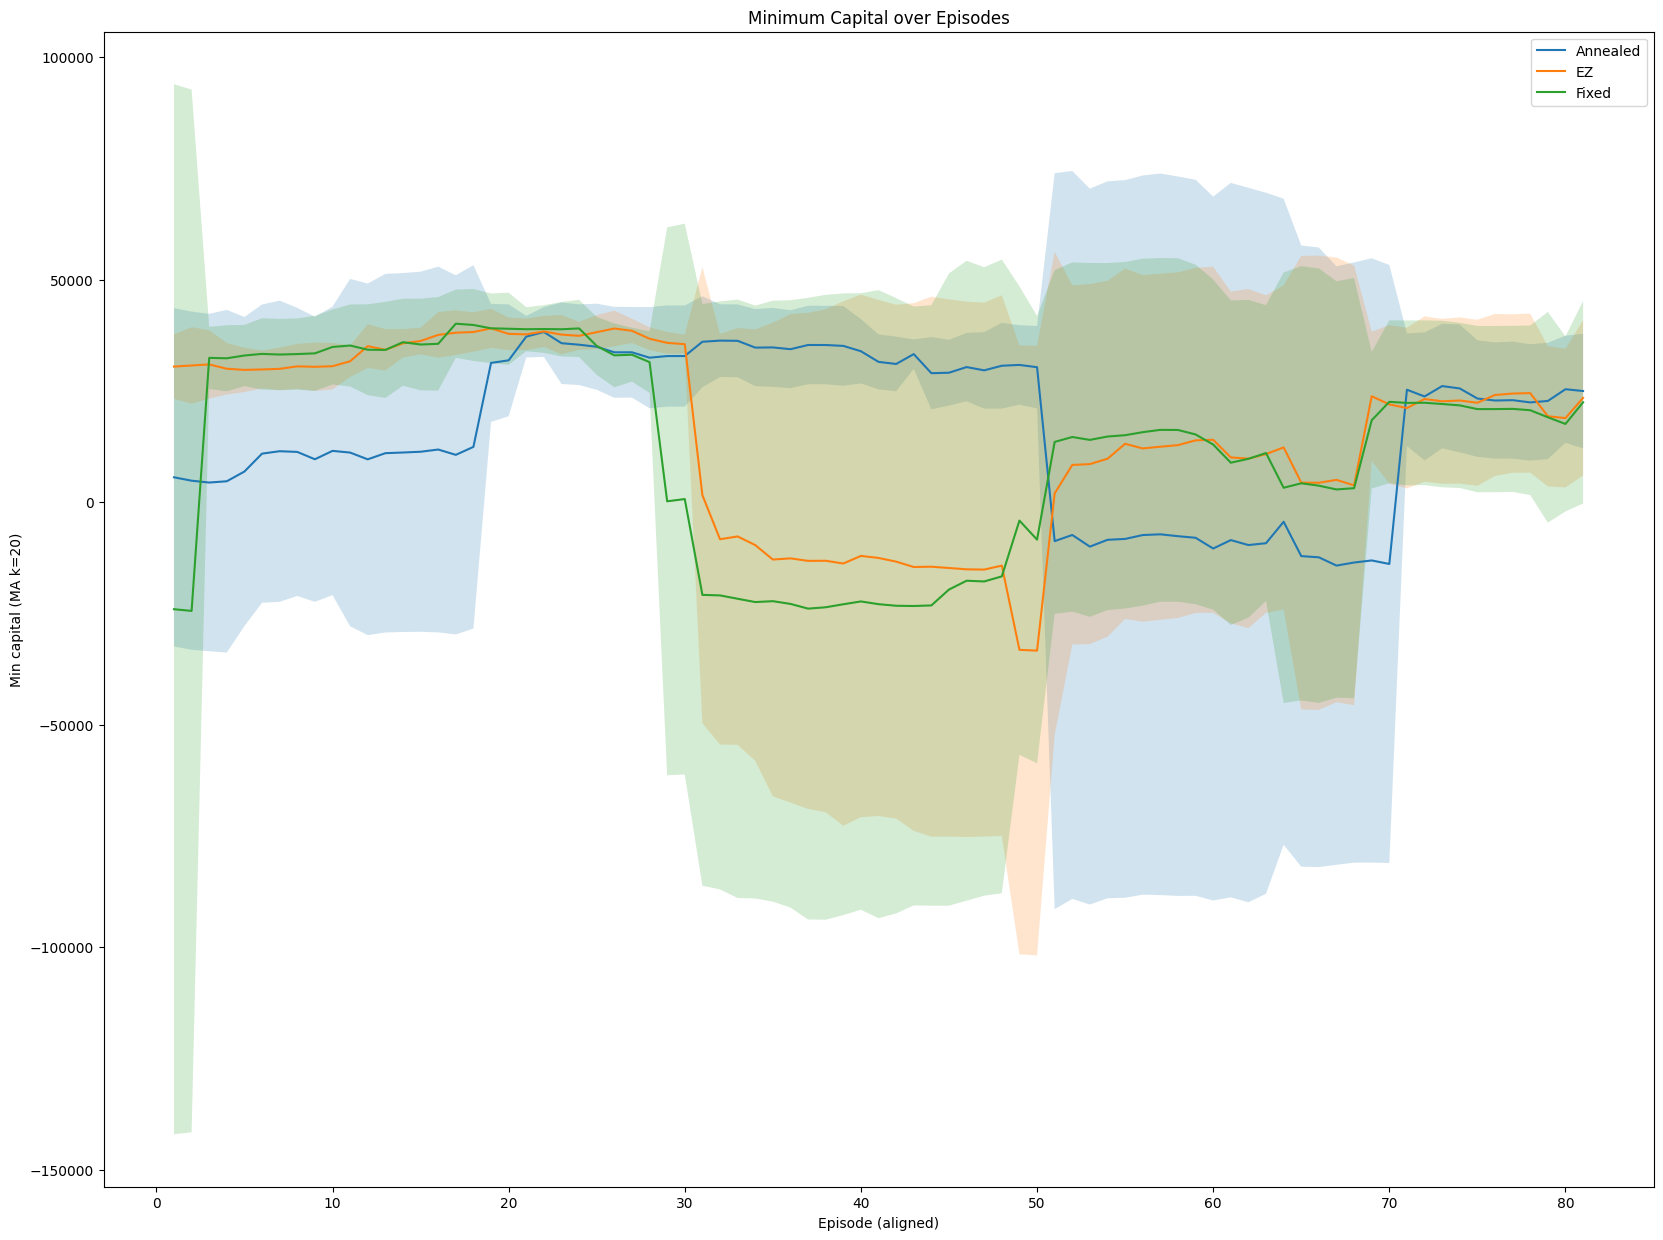

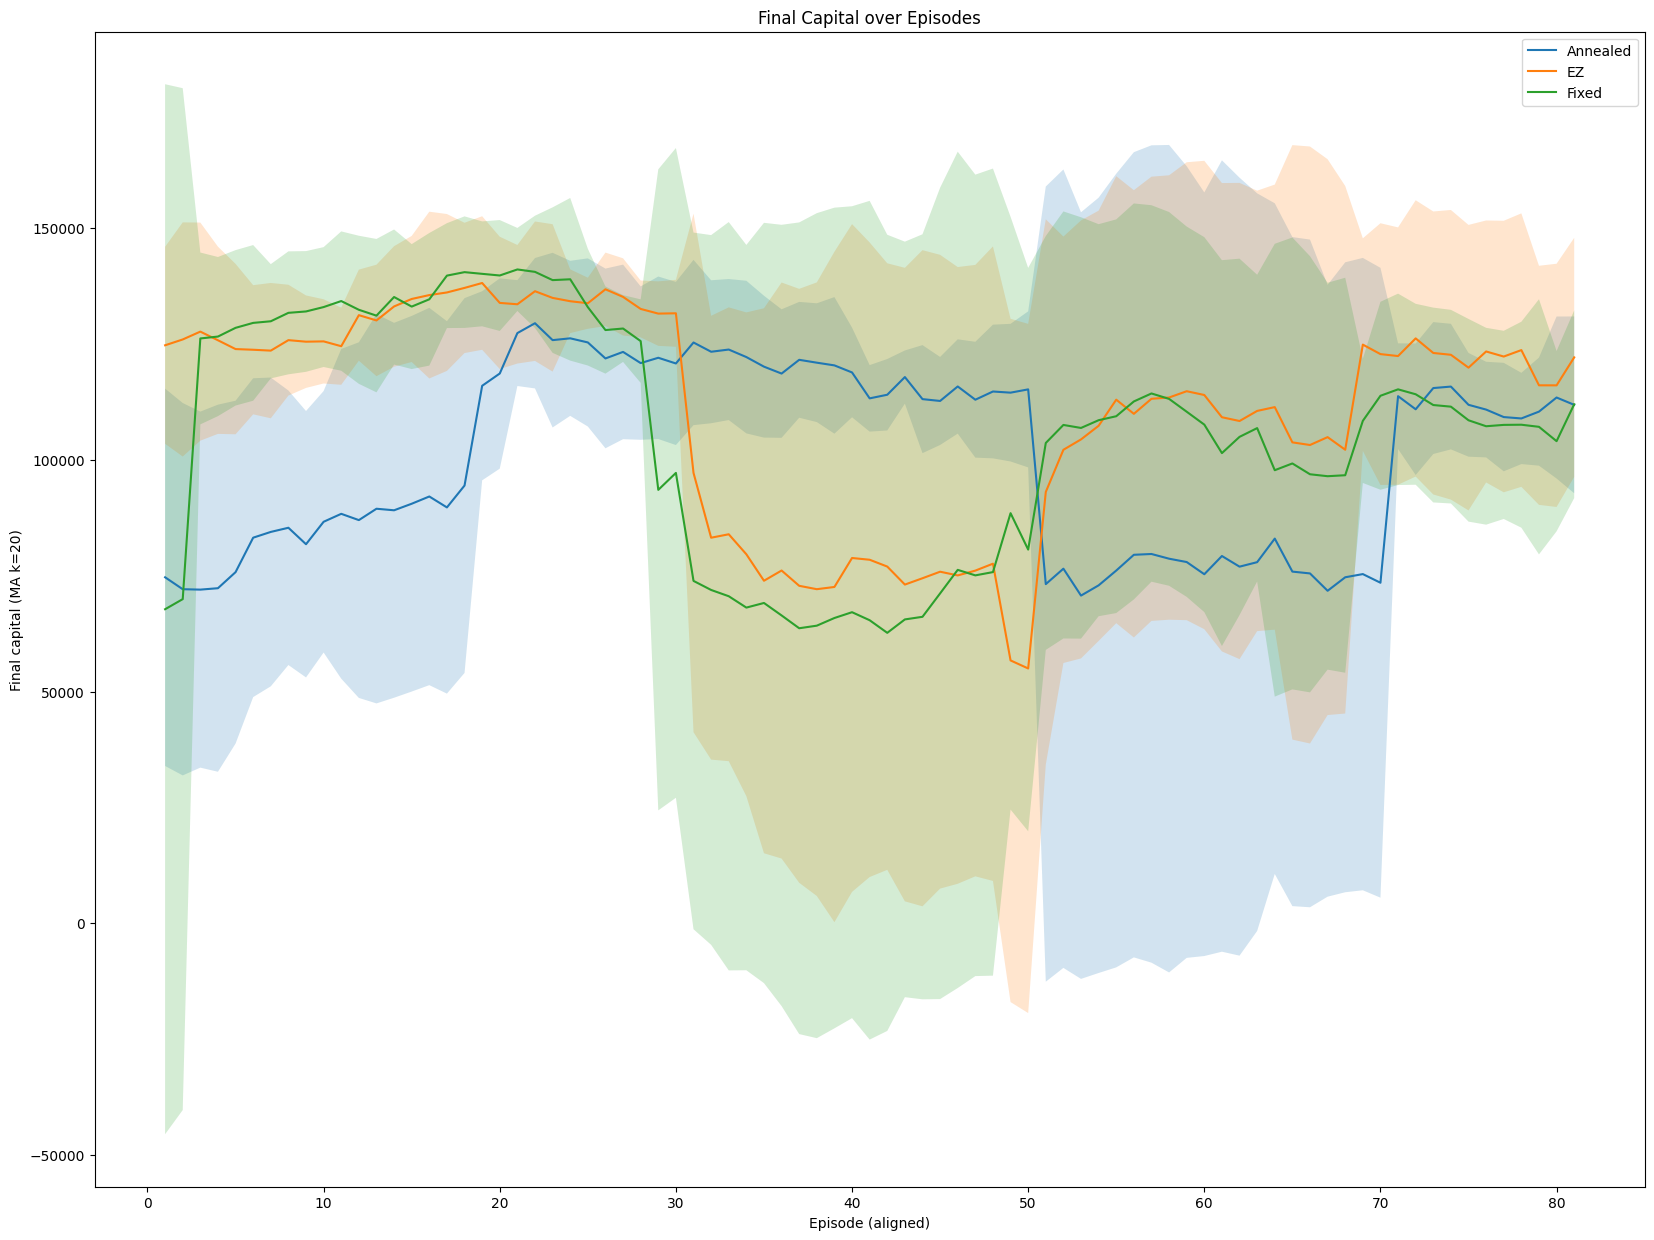

In [56]:

if train_df.empty:
    print("No training metrics found.")
else:
    # Min capital
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="min_capital", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Min capital (MA k=20)")
    ax.set_title("Minimum Capital over Episodes")
    ax.legend()
    plt.show()

    # Final capital
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="final_capital", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Final capital (MA k=20)")
    ax.set_title("Final Capital over Episodes")
    ax.legend()
    plt.show()


## Bankruptcy rate (moving-average, robust)

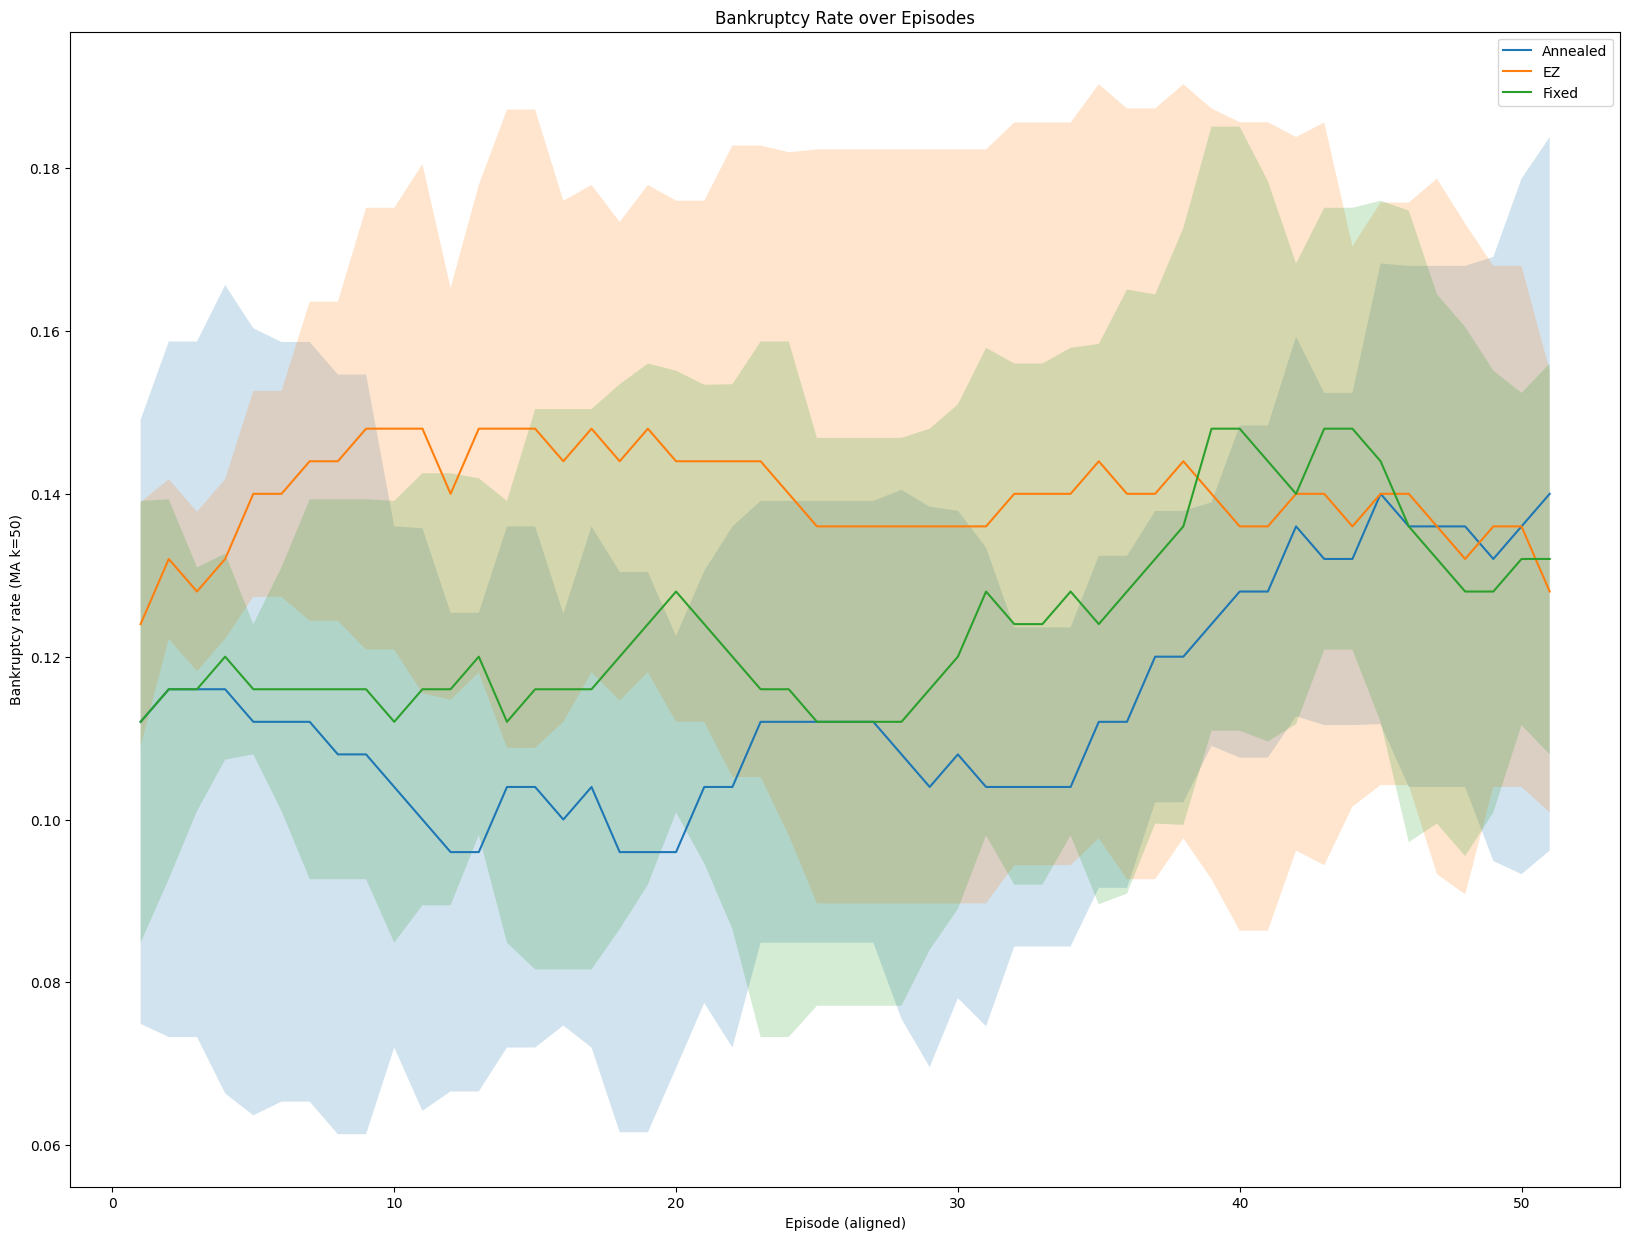

In [57]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="bankrupt", ma_k=50)
        if len(x) > 0 and ys:
            # bankrupt is 0/1; MA makes it a rate
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Bankruptcy rate (MA k=50)")
    ax.set_title("Bankruptcy Rate over Episodes")
    ax.legend()
    plt.show()


## Exploration dynamics (robust)

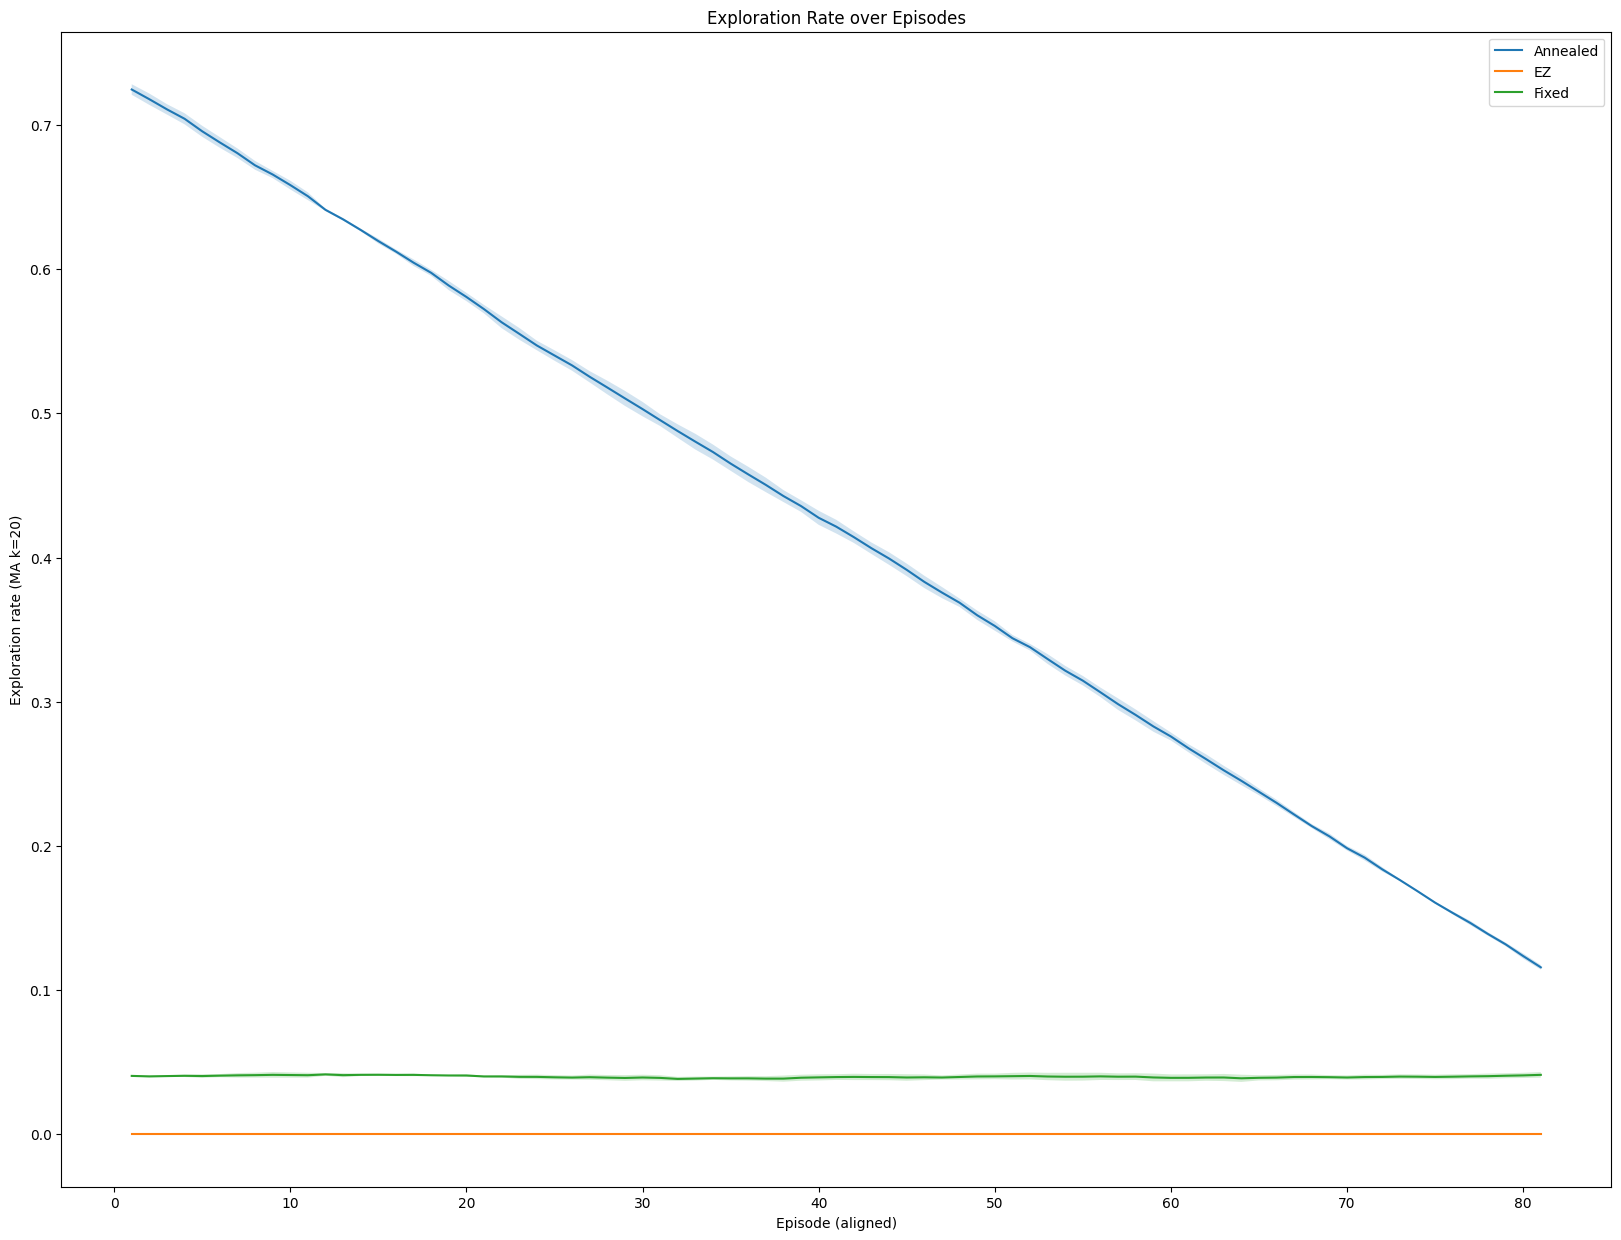

In [58]:

if train_df.empty or "exploration_rate" not in train_df.columns:
    print("No exploration metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="exploration_rate", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Exploration rate (MA k=20)")
    ax.set_title("Exploration Rate over Episodes")
    ax.legend()
    plt.show()


## EZ-Greedy details (robust)

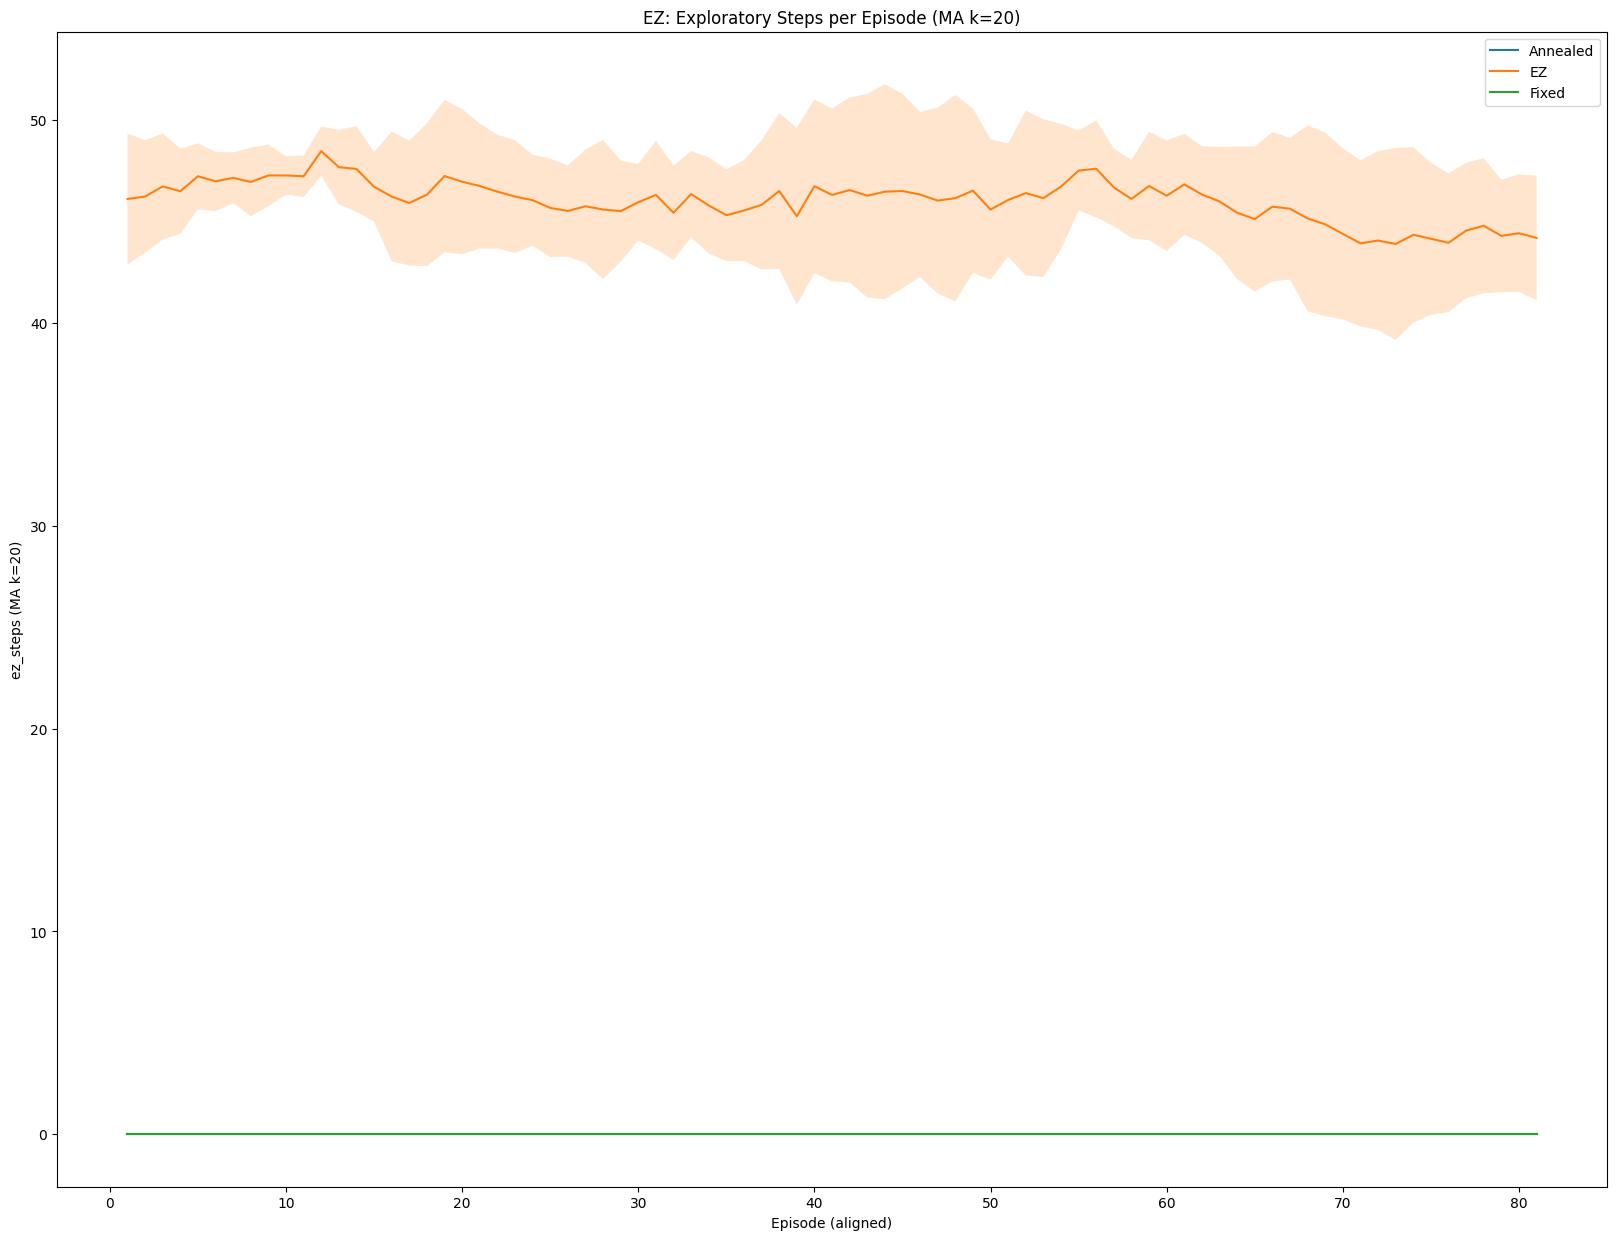

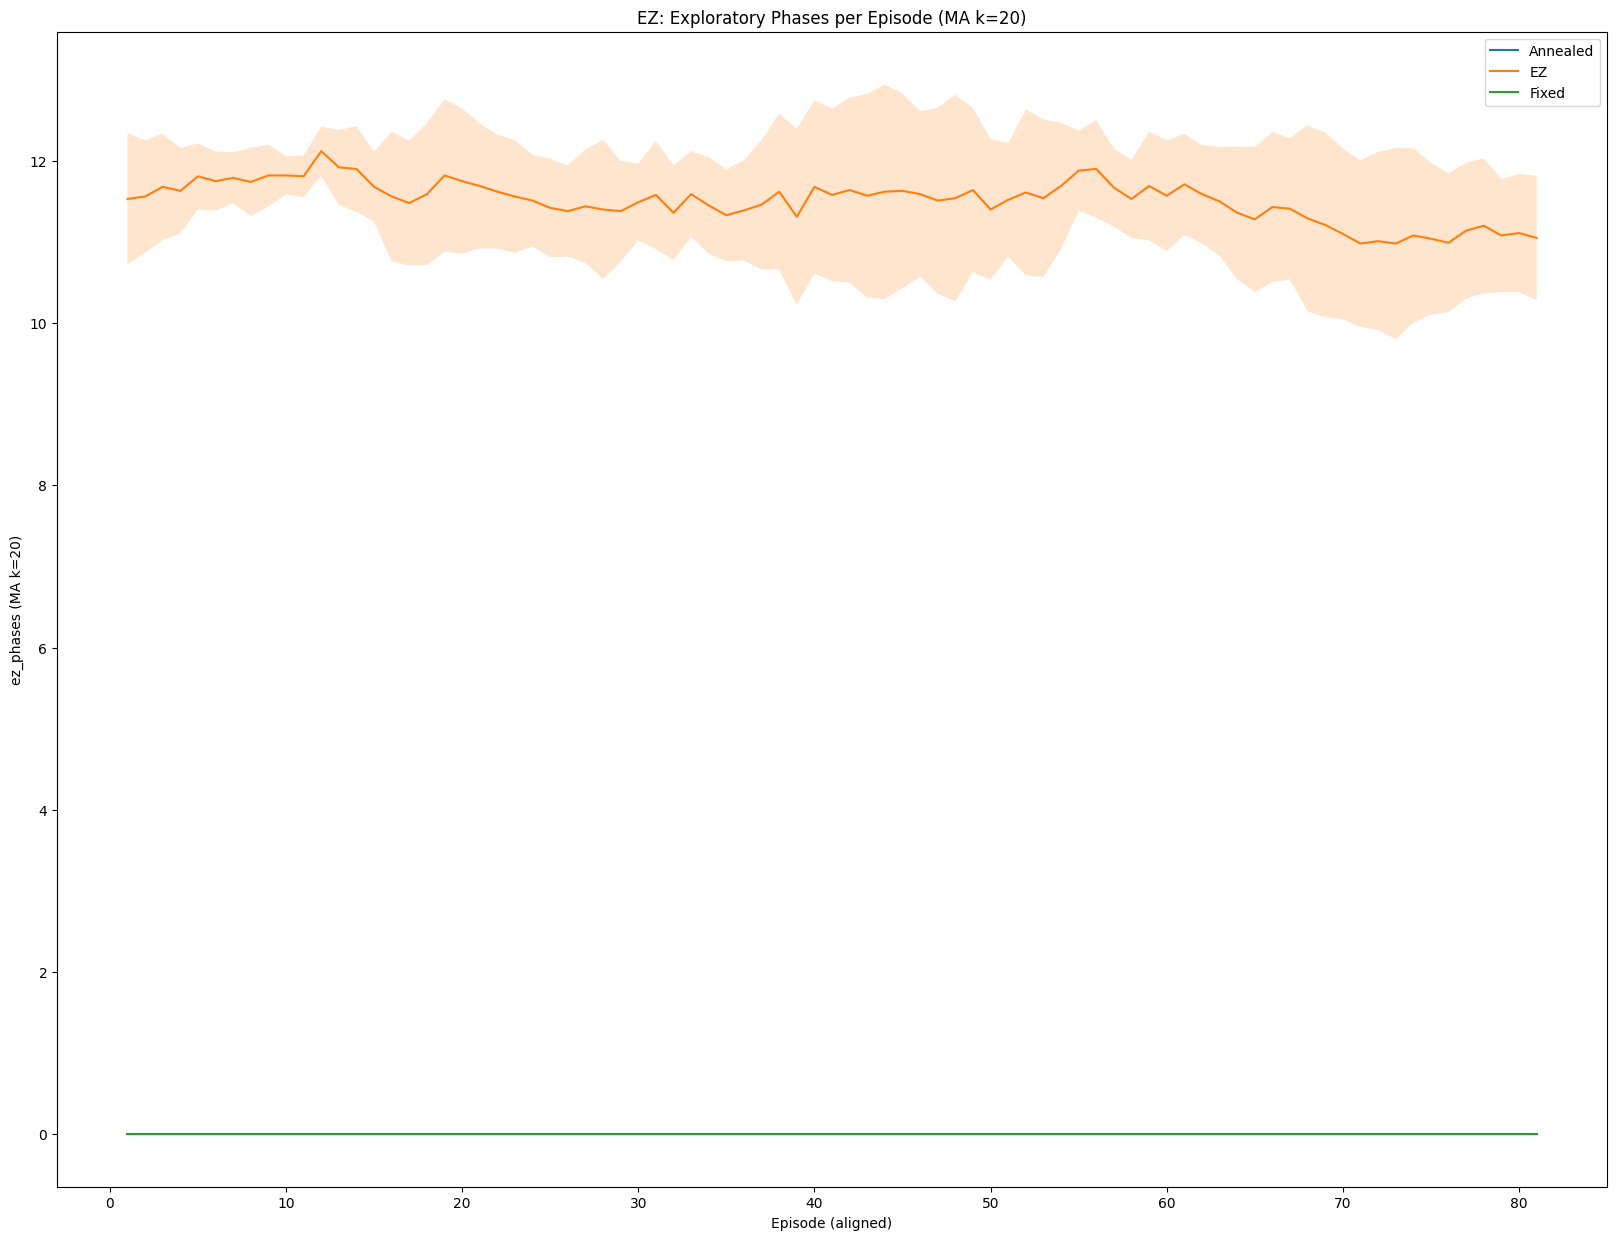

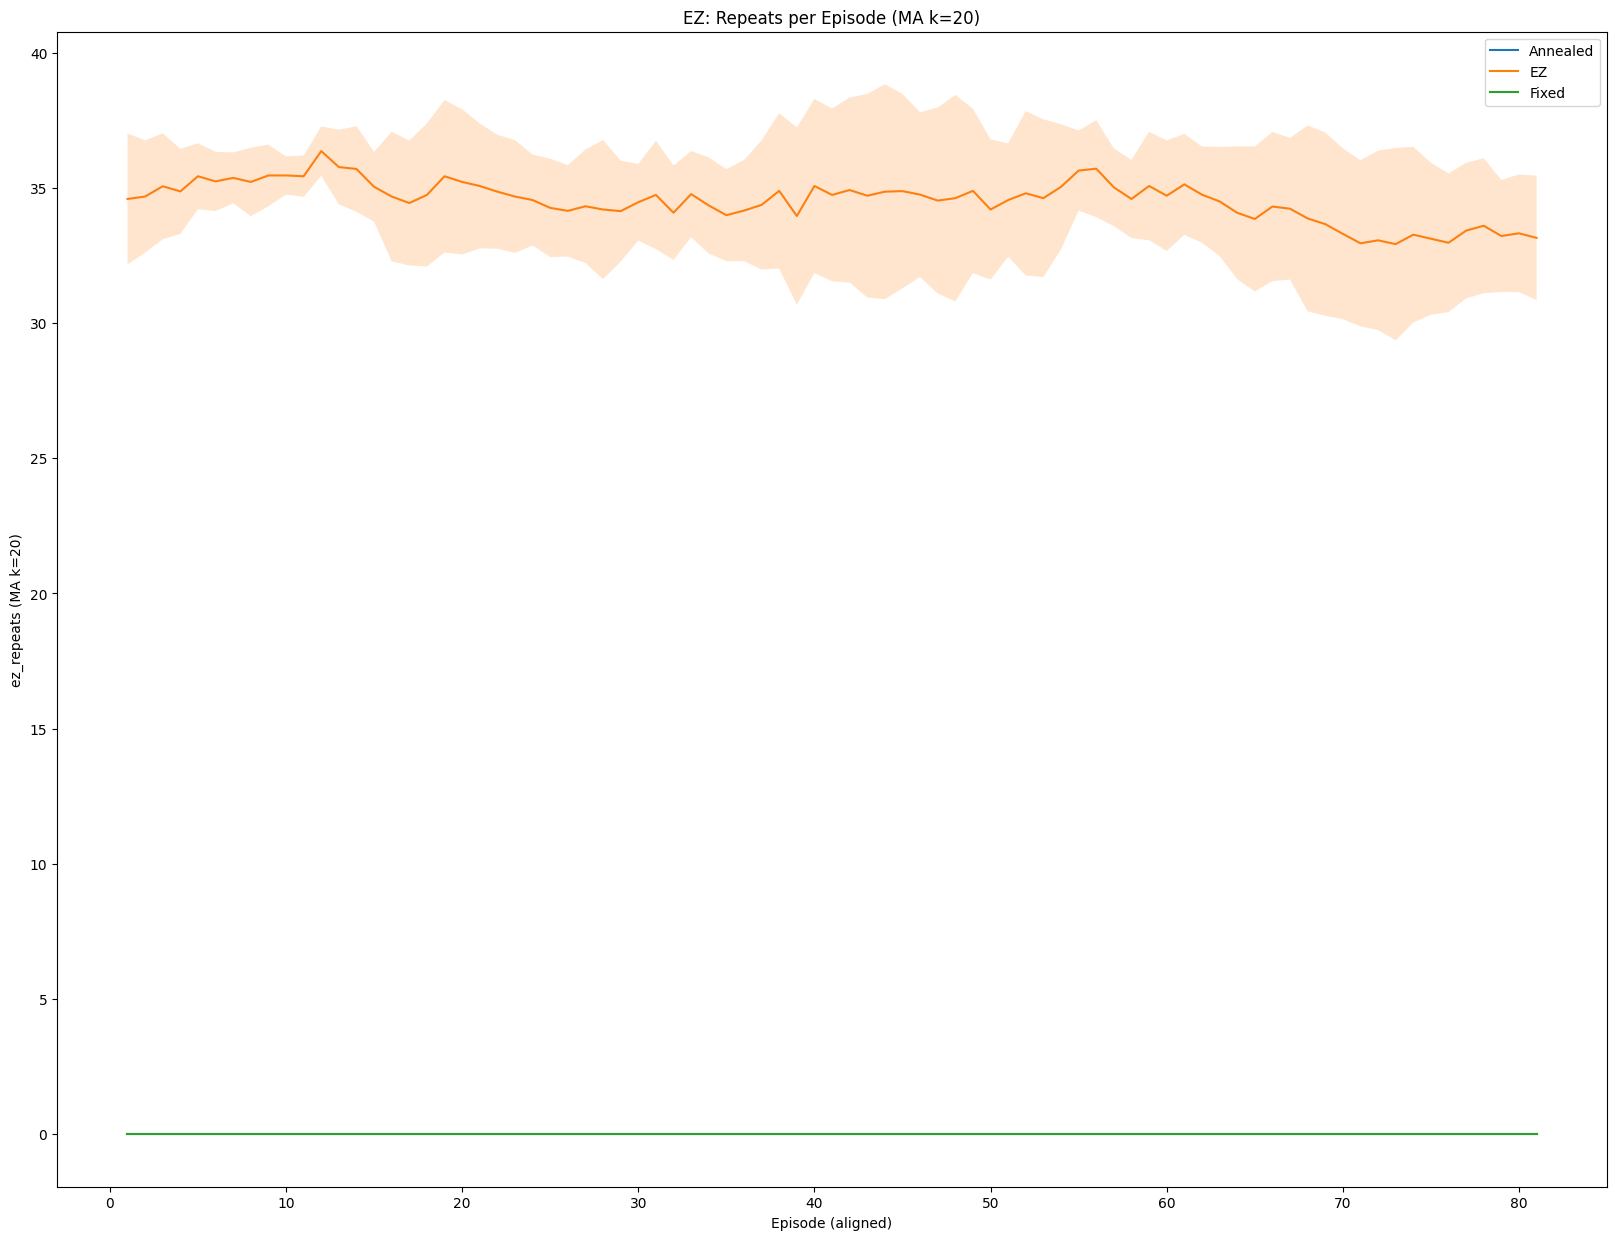

In [59]:

if train_df.empty:
    print("No training metrics found.")
else:
    for metric, title in [
        ("ez_steps", "EZ: Exploratory Steps per Episode (MA k=20)"),
        ("ez_phases", "EZ: Exploratory Phases per Episode (MA k=20)"),
        ("ez_repeats", "EZ: Repeats per Episode (MA k=20)"),
    ]:
        fig = plt.figure(figsize=(20,15))
        ax = plt.gca()
        for v, g in train_df.groupby("variant"):
            x, ys = prepare_variant_series(g, value_col=metric, ma_k=20)
            if len(x) > 0 and ys:
                plot_mean_std(ax, x, ys, label=v)
        ax.set_xlabel("Episode (aligned)")
        ax.set_ylabel(metric + " (MA k=20)")
        ax.set_title(title)
        ax.legend()
        plt.show()


## Evaluation blocks (greedy policy)

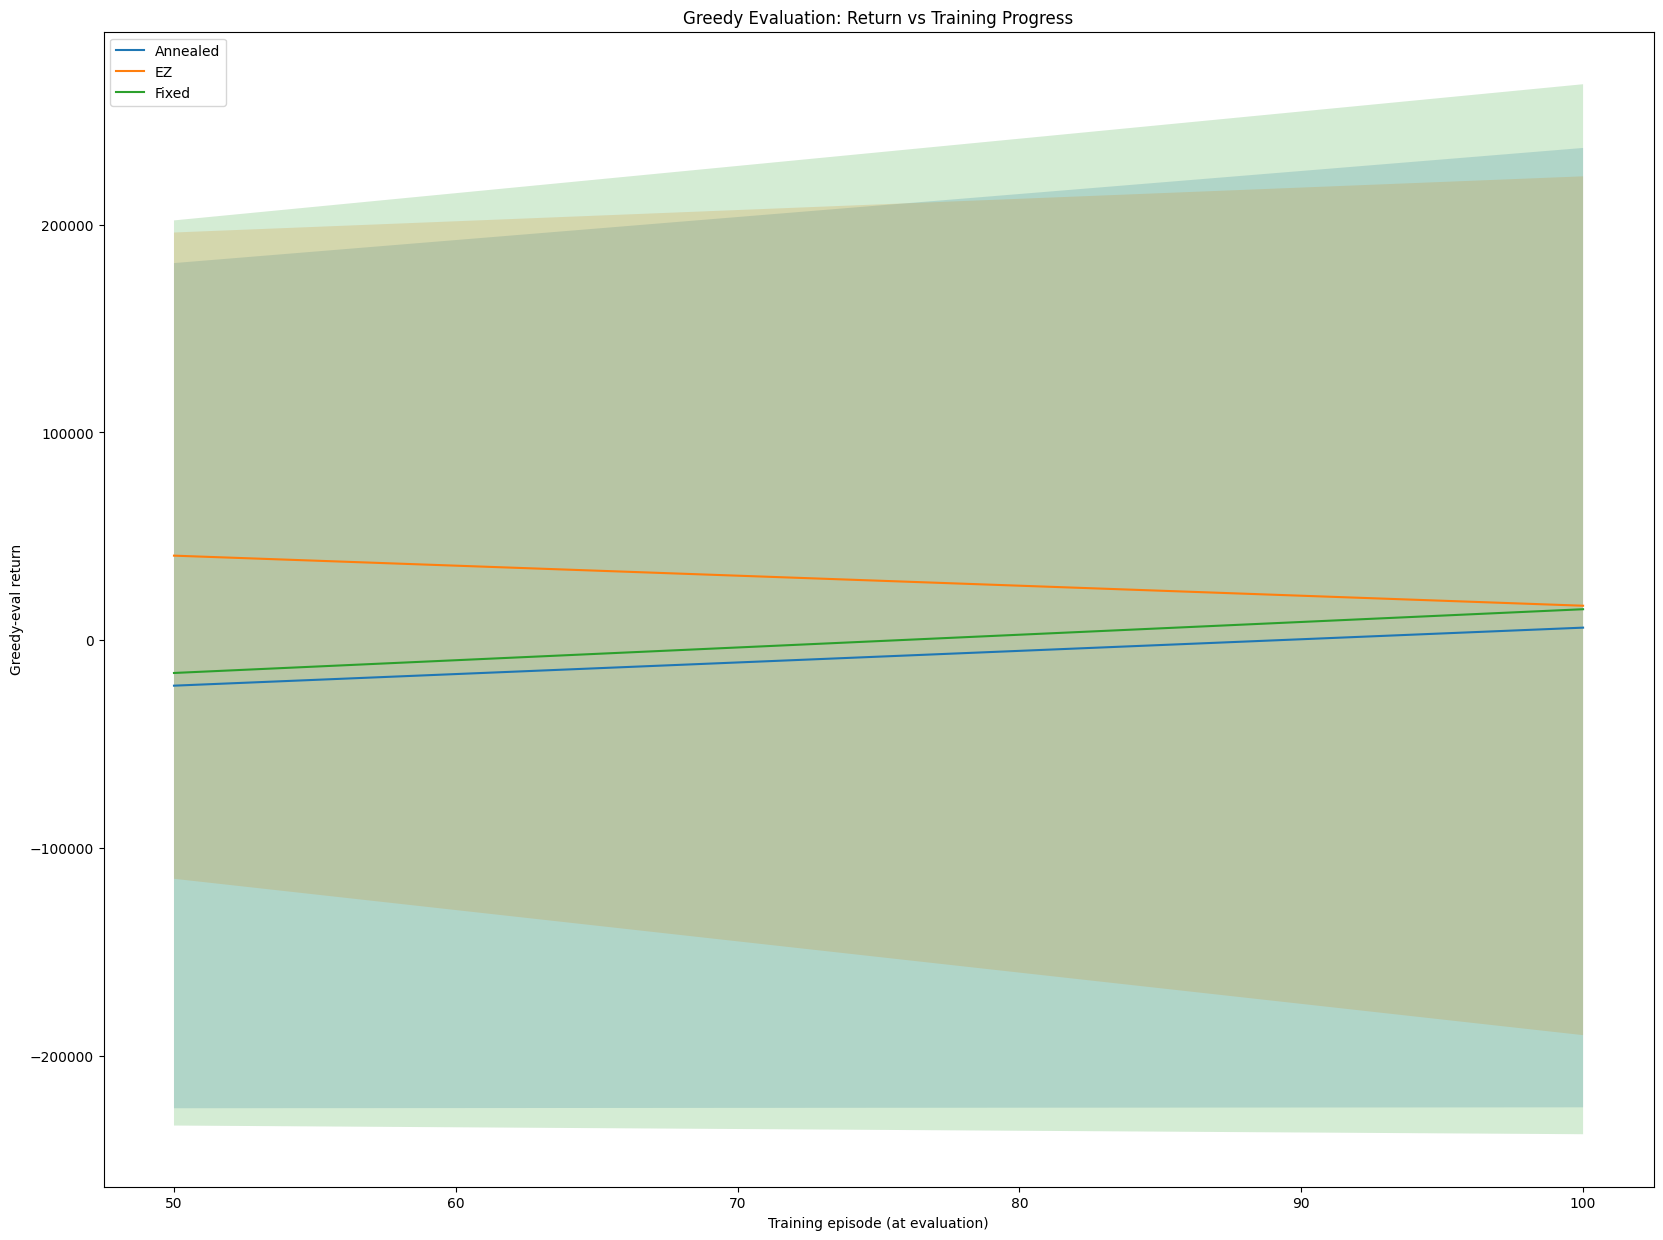

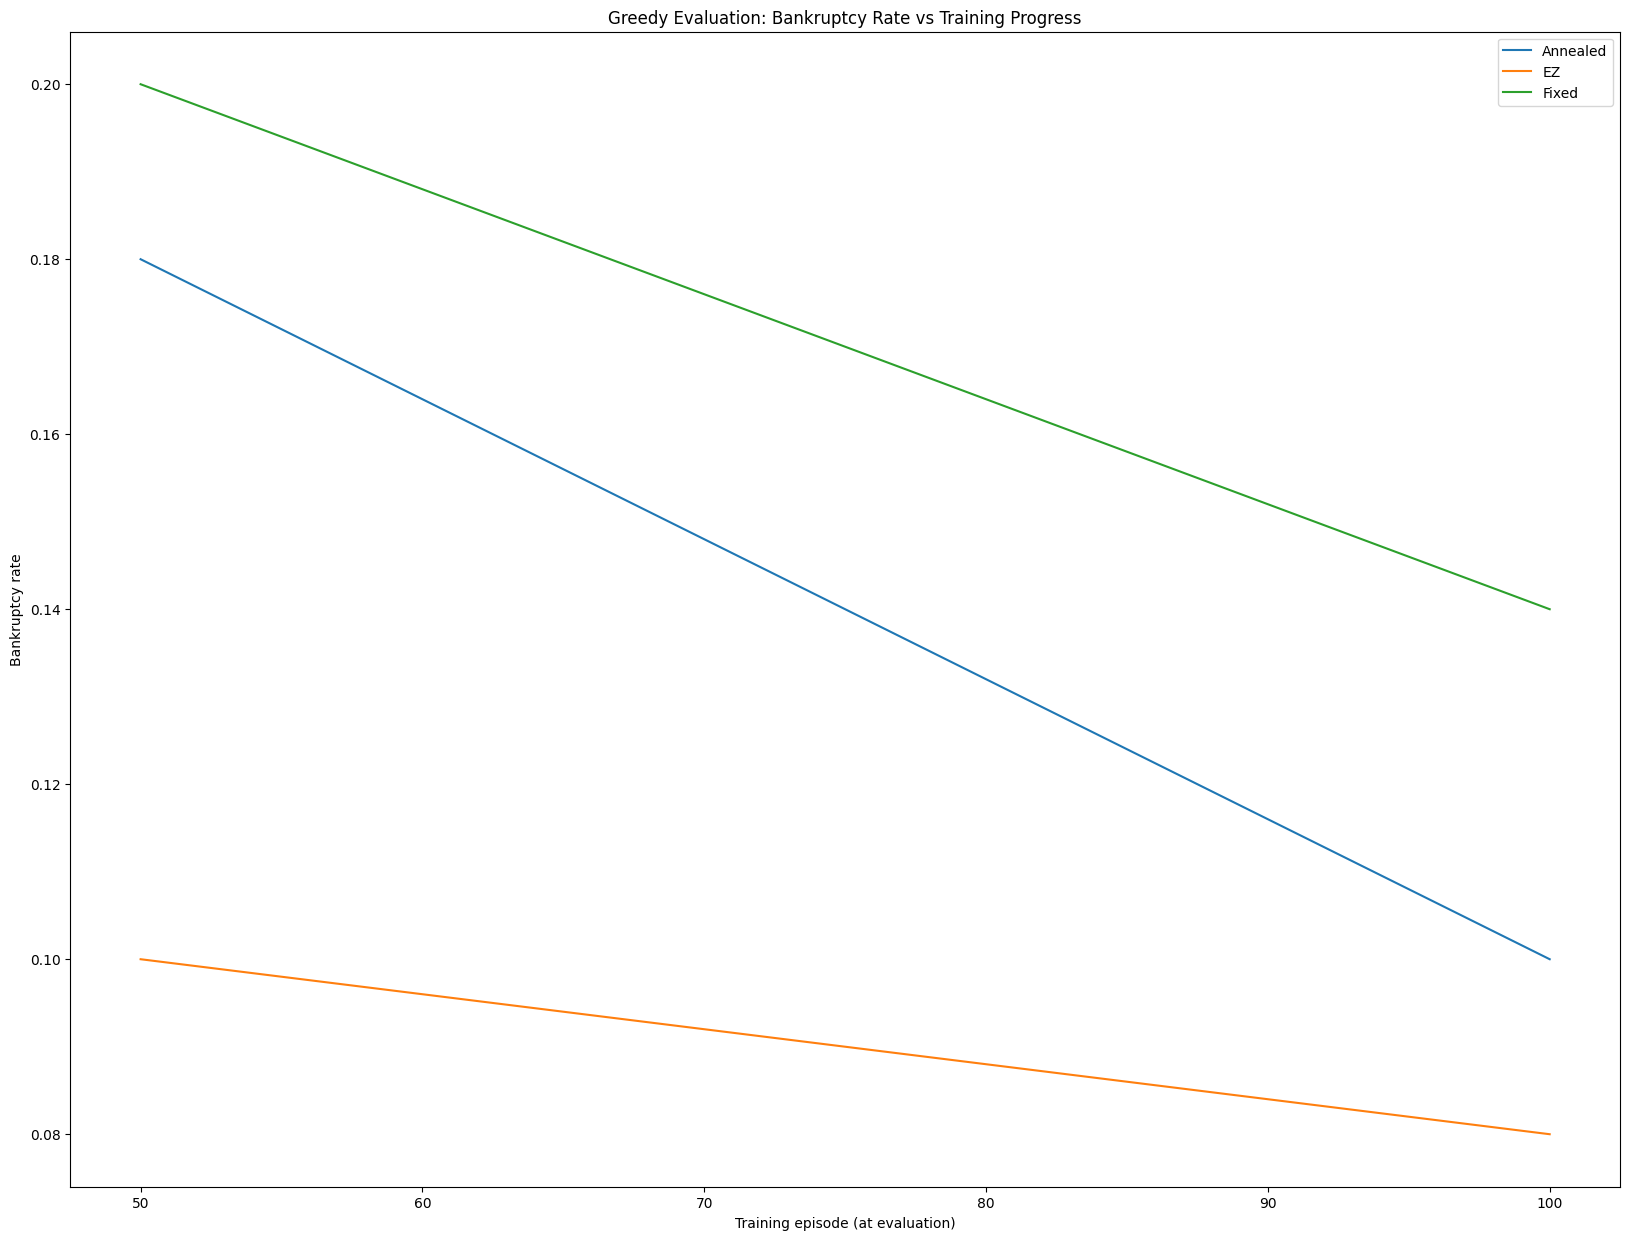

In [60]:

if eval_df.empty:
    print("No eval data found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in eval_df.groupby("variant"):
        agg = g.groupby("block_episode")["return"].agg(["mean", "std"]).reset_index()
        ax.plot(agg["block_episode"], agg["mean"], label=v)
        ax.fill_between(agg["block_episode"], agg["mean"] - agg["std"], agg["mean"] + agg["std"], alpha=0.2)
    ax.set_xlabel("Training episode (at evaluation)")
    ax.set_ylabel("Greedy-eval return")
    ax.set_title("Greedy Evaluation: Return vs Training Progress")
    ax.legend()
    plt.show()

    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in eval_df.groupby("variant"):
        agg = g.groupby("block_episode")["bankrupt"].mean().reset_index()
        ax.plot(agg["block_episode"], agg["bankrupt"], label=v)
    ax.set_xlabel("Training episode (at evaluation)")
    ax.set_ylabel("Bankruptcy rate")
    ax.set_title("Greedy Evaluation: Bankruptcy Rate vs Training Progress")
    ax.legend()
    plt.show()


## Losses and claims (robust)

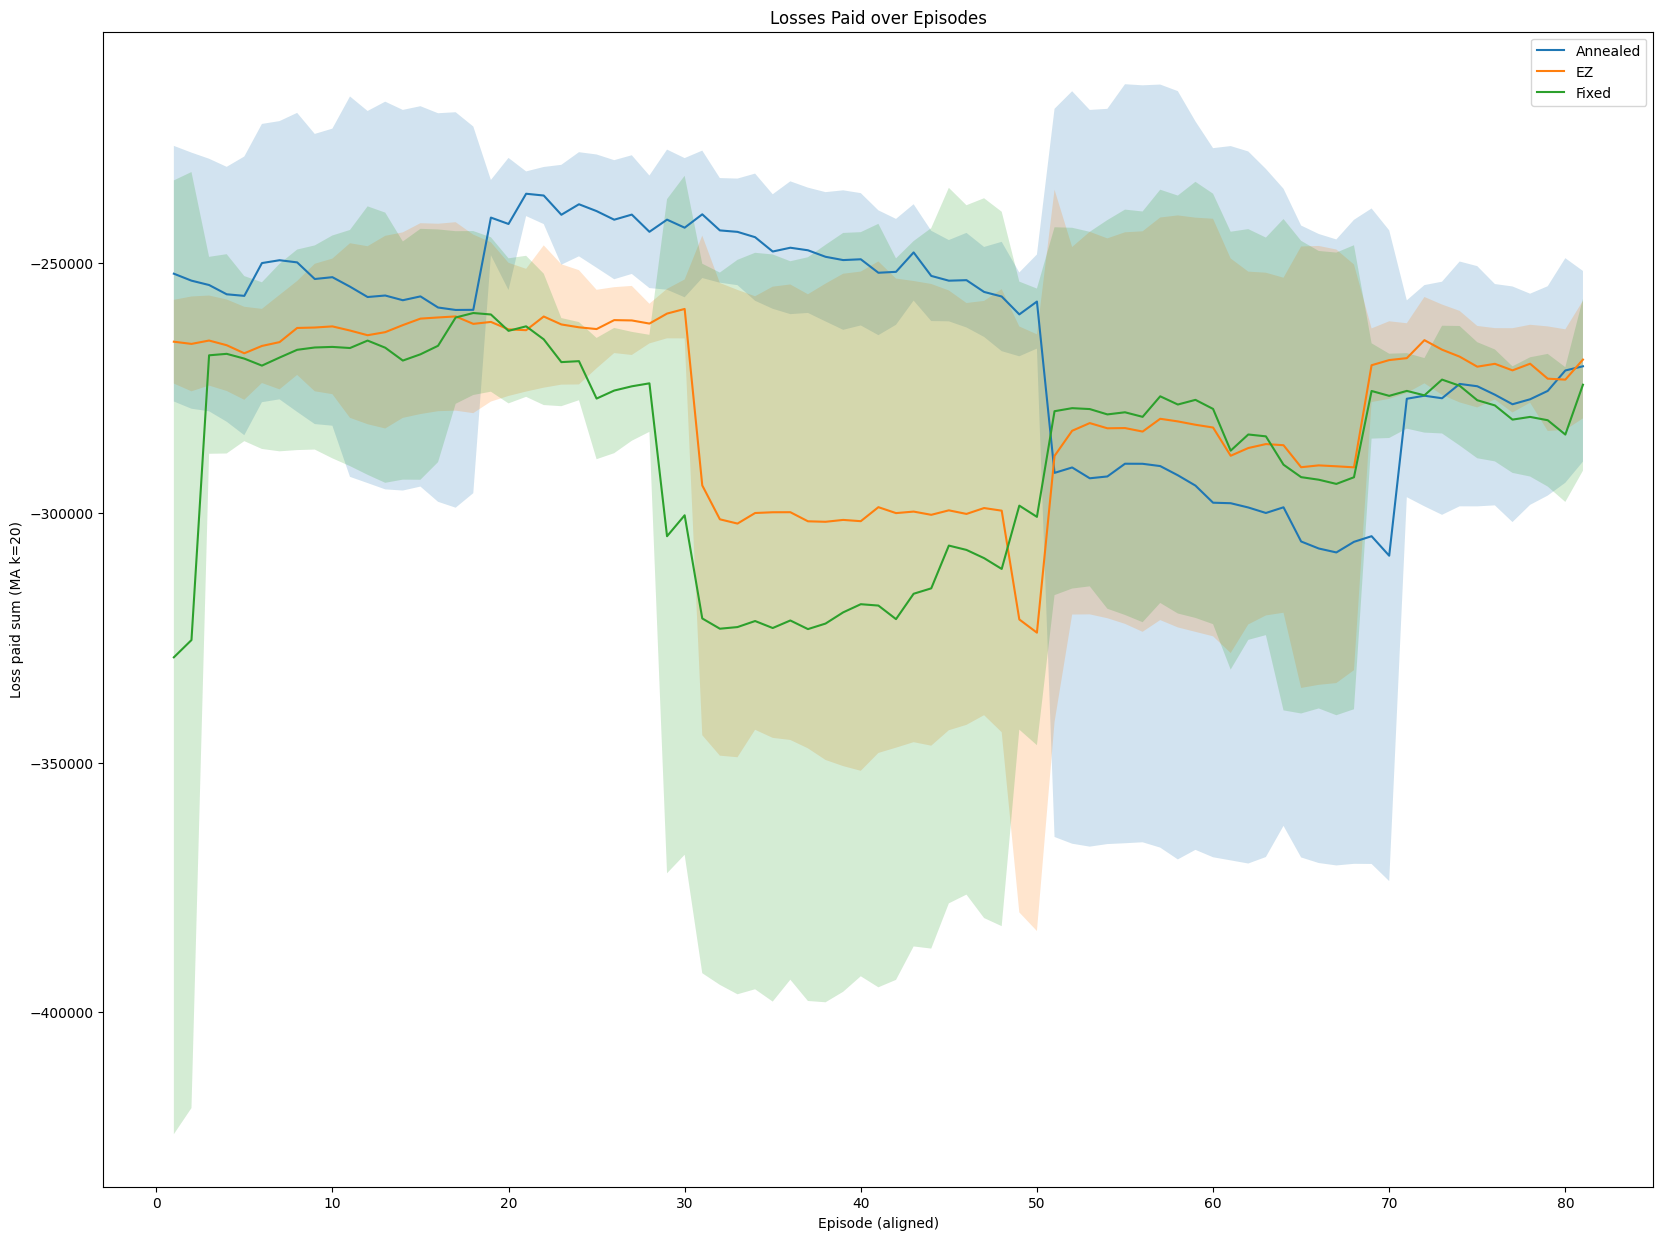

In [61]:

if train_df.empty:
    print("No training metrics found.")
else:
    fig = plt.figure(figsize=(20,15))
    ax = plt.gca()
    for v, g in train_df.groupby("variant"):
        x, ys = prepare_variant_series(g, value_col="loss_paid_sum", ma_k=20)
        if len(x) > 0 and ys:
            plot_mean_std(ax, x, ys, label=v)
    ax.set_xlabel("Episode (aligned)")
    ax.set_ylabel("Loss paid sum (MA k=20)")
    ax.set_title("Losses Paid over Episodes")
    ax.legend()
    plt.show()



## Summary table (last episode per seed)

In [62]:

if train_df.empty:
    print("No training metrics found.")
else:
    last_ep = train_df.groupby(["variant","seed"])["episode"].max().reset_index()
    merged = train_df.merge(last_ep, on=["variant","seed","episode"], how="inner")
    display_cols = ["variant","seed","return","final_capital","bankrupt","accept_rate","avg_premium"]
    merged[display_cols].sort_values(["variant","seed"])
